In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rd
from sklearn.decomposition import PCA

In [70]:
# load data

df = pd.read_csv("CARS_1.csv")

In [71]:
# clean and normalize data

def normalize(df, columnName):
    maxVal = df[columnName].max()
    df[columnName] = df[columnName].divide(maxVal)
    
def mapStrToInt(df, columnName):
    uniqueStrs = df[columnName].unique()
    strToIntDict = dict([(y, x + 1) for x, y in enumerate(uniqueStrs)])
    for index, row in df.iterrows():
        df.loc[index, columnName] = strToIntDict[row[columnName]]

startingPrice = df["starting_price"]
endingPrice = df["ending_price"]

df.drop(columns = ["reviews_count", "rating", "starting_price", "ending_price"], inplace = True)
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
strColumns = ["fuel_type", "transmission_type", "body_type"]

for columnName in strColumns:
    if columnName != "car_name":
        mapStrToInt(df, columnName)
        df = df.astype({columnName:'int'})
    

for columnName in df.columns:
    if columnName != "car_name":
        normalize(df, columnName)
        

In [5]:
# add weights to the most variable data

weights = {}
for column in df.columns:
    if column != "car_name":
        weights[column] = df[column].std()
sortedWeights = sorted(weights, key=weights.get, reverse=True)[:10]

weight = 30
for column in sortedWeights:
    df[column] = df[column] * weight
    weight -= 2.5

In [6]:
# k means algorithm

def euclidDistance(xFTyp, xEngDisp, xNoCyl, xSeatCap, xTranTyp, xFTnkCap, xBType, xTrqNM, xTrqRPM, xPwrBHP, xPwrRP,
                   yFTyp, yEngDisp, yNoCyl, ySeatCap, yTranTyp, yFTnkCap, yBType, yTrqNM, yTrqRPM, yPwrBHP, yPwrRP):
    
    return np.sqrt((xFTyp - yFTyp) ** 2 + (xEngDisp - yEngDisp) ** 2 + (xNoCyl - yNoCyl) ** 2 + (xSeatCap - ySeatCap) ** 2 + (xTranTyp - yTranTyp) ** 2 +
                   (xFTnkCap - yFTnkCap) ** 2 + (xBType - yBType) ** 2 + (xTrqNM - yTrqNM) ** 2 + (xTrqRPM - yTrqRPM) ** 2 + (xPwrBHP - yPwrBHP) ** 2 + 
                   (xPwrRP - yPwrRP) ** 2)
    
def kmeans(df, k, tol):
    reconError = 100
    oldError = 0
    newError = 0
    differences = [0] * k
    totalDifferences = 0
    centroids = [0] * k
    clusters = [-1] * len(df)
    randomNums = rd.sample(range(0, len(df)), k)
    
    for i, num in enumerate(randomNums):
        centroids[i] = df.iloc[num]
    
    for index in range(len(df)):
        for j in range(k):
            differences[j] = euclidDistance(df.iloc[index]["fuel_type"], df.iloc[index]["engine_displacement"], df.iloc[index]["no_cylinder"], df.iloc[index]["seating_capacity"],
                                            df.iloc[index]["transmission_type"], df.iloc[index]["fuel_tank_capacity"], df.iloc[index]["body_type"], df.iloc[index]["max_torque_nm"],
                                            df.iloc[index]["max_torque_rpm"], df.iloc[index]["max_power_bhp"], df.iloc[index]["max_power_rp"], 
                                            centroids[j]["fuel_type"], centroids[j]["engine_displacement"], centroids[j]["no_cylinder"], centroids[j]["seating_capacity"],
                                            centroids[j]["transmission_type"], centroids[j]["fuel_tank_capacity"], centroids[j]["body_type"], centroids[j]["max_torque_nm"],
                                            centroids[j]["max_torque_rpm"], centroids[j]["max_power_bhp"], centroids[j]["max_power_rp"])
        totalDifferences += min(differences)
        clusters[index] = differences.index(min(differences)) # get the index associated with the lowest euclid distance, this index is the centroid this node is assigned to
    oldError = totalDifferences / len(df) # this code is confirmed working

    while reconError > tol:
        centroids = np.zeros((k, 11))
        differences = [0] * k
        totalDifferences = 0
        for a in range(k):
            averageFTyp = 0
            averageEngDisp = 0
            averageNoCyl = 0
            averageSeatCap = 0
            averageTranTyp = 0
            averageFTypCap = 0
            averageBTyp = 0
            averageTrqNM = 0
            averageTrqRPM = 0
            averagePwrBHP = 0
            averagePwrRP = 0
            length = 1
            for b in range(len(df)):
                if clusters[b] == a:
                    averageFTyp += df.iloc[b]["fuel_type"]
                    averageEngDisp += df.iloc[b]["engine_displacement"]
                    averageNoCyl += df.iloc[b]["no_cylinder"]
                    averageSeatCap += df.iloc[b]["seating_capacity"]
                    averageTranTyp += df.iloc[b]["transmission_type"]
                    averageFTypCap += df.iloc[b]["fuel_tank_capacity"]
                    averageBTyp += df.iloc[b]["body_type"]
                    averageTrqNM += df.iloc[b]["max_torque_nm"]
                    averageTrqRPM += df.iloc[b]["max_torque_rpm"]
                    averagePwrBHP += df.iloc[b]["max_power_bhp"]
                    averagePwrRP += df.iloc[b]["max_power_rp"]
                    length += 1
            centroids[a] = [(averageFTyp / length), (averageEngDisp / length), (averageNoCyl / length), (averageSeatCap / length), (averageTranTyp / length), (averageFTypCap / length), (averageBTyp / length), (averageTrqNM / length), (averageTrqRPM / length), (averagePwrBHP / length), (averagePwrRP / length)]
            
        for index in range(len(df)):
            for c in range(k):
                differences[c] = euclidDistance(df.iloc[index]["fuel_type"], df.iloc[index]["engine_displacement"], df.iloc[index]["no_cylinder"], df.iloc[index]["seating_capacity"],
                                        df.iloc[index]["transmission_type"], df.iloc[index]["fuel_tank_capacity"], df.iloc[index]["body_type"], df.iloc[index]["max_torque_nm"],
                                        df.iloc[index]["max_torque_rpm"], df.iloc[index]["max_power_bhp"], df.iloc[index]["max_power_rp"], 
                                        centroids[c][0], centroids[c][1], centroids[c][2], centroids[c][3],
                                        centroids[c][4], centroids[c][5], centroids[c][6], centroids[c][7],
                                        centroids[c][8], centroids[c][9], centroids[c][10])
            totalDifferences += min(differences)
            clusters[index] = differences.index(min(differences))
            
        newError = totalDifferences / len(df)
        reconError = abs(oldError - newError)
        if reconError <= tol:
            return centroids, clusters, newError
        oldError = newError

In [ ]:
# selecting the best value for k

meanErrors = [0] * 9
for n in range(1, 10):
    temp = float('inf')
    for i in range(10):
        centroids, clusters, error = kmeans(df, n, 0.05)
        temp = min(temp, error)
    meanErrors[n - 1] = temp
    
plt.figure(figsize = (13, 6))
plt.title("Elbow Chart for Various Values of K")
plt.xlabel("K")
plt.ylabel("Error")
plt.scatter((1, 2, 3, 4, 5, 6, 7, 8, 9), meanErrors)
plt.show()
plt.close()

In [7]:
# best value for k is 4 according to the chart above

k = 4
centroids = []
clusters = []
error = float('inf')
tempError = 0
tempClusters = []
tempCentroids = []

for x in range(20):
    tempCentroids, tempClusters, tempError = kmeans(df, k, 0.05)
    if tempError < error:
        centroids = tempCentroids
        clusters = tempClusters
        error = tempError

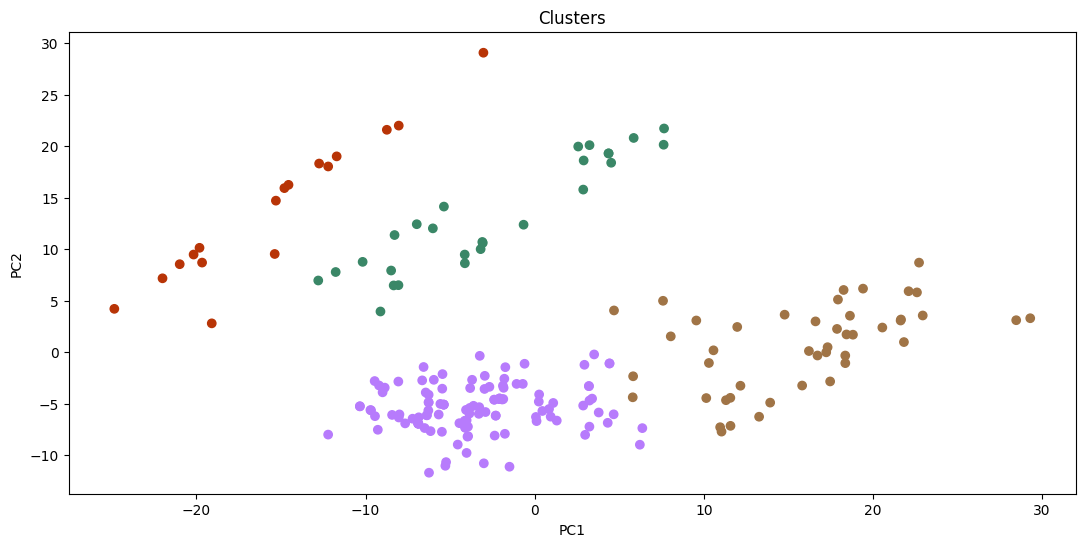

In [11]:
# visualize using primary component analysis

PCA2D = PCA(n_components = 2)
solved = pd.DataFrame(PCA2D.fit_transform(df.drop(["car_name"], axis = 1)))
solved.columns = ["PC1", "PC2"]

# https://www.kaggle.com/code/minc33/visualizing-high-dimensional-clusters/notebook#Clustering:

colors = [""] * len(clusters)
names = [""] * len(clusters)
for i in range(k):
    color = "#%06x".upper() % rd.randint(0, 0xFFFFFF)
    for j in range(len(clusters)):
        if clusters[j] == i:
            colors[j] = color
            
freq = {x: 0 for x in range(k)}
for cluster in clusters:
    freq[cluster] = freq.get(cluster) + 1

plt.figure(figsize = (13, 6))
plt.title("Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter([x for x in solved['PC1']], [x for x in solved['PC2']], c = colors)
plt.show()
plt.close()

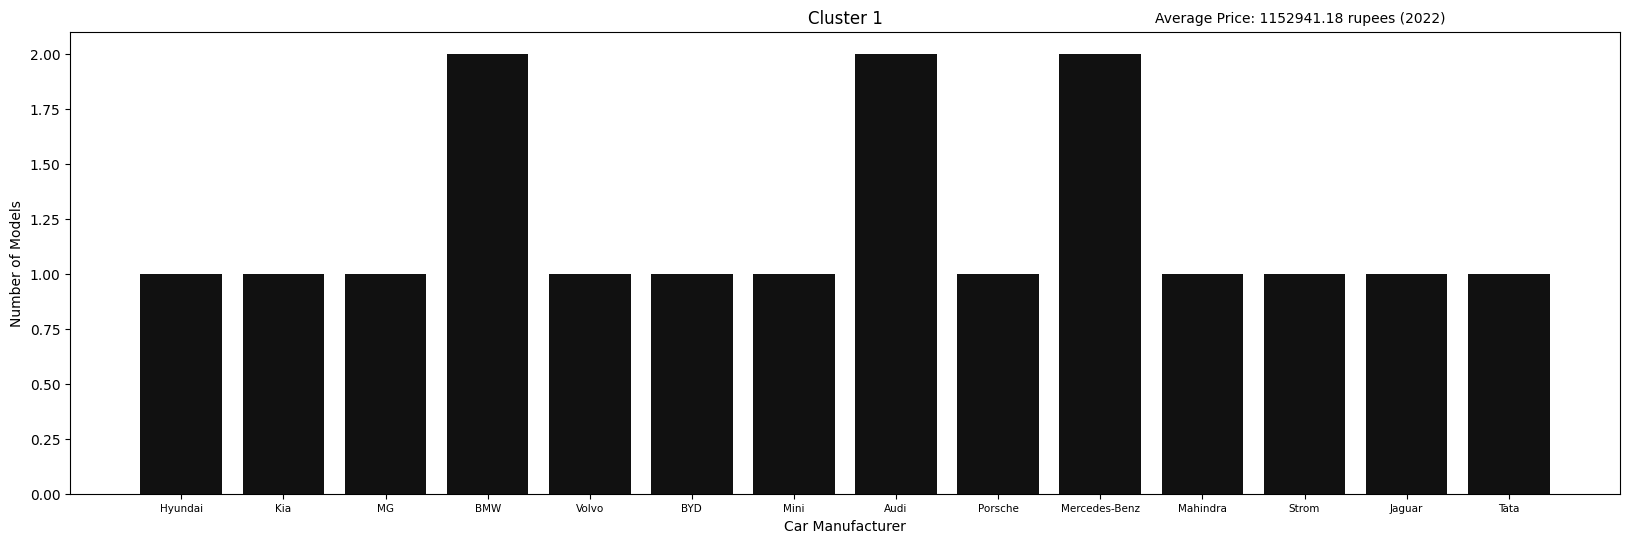

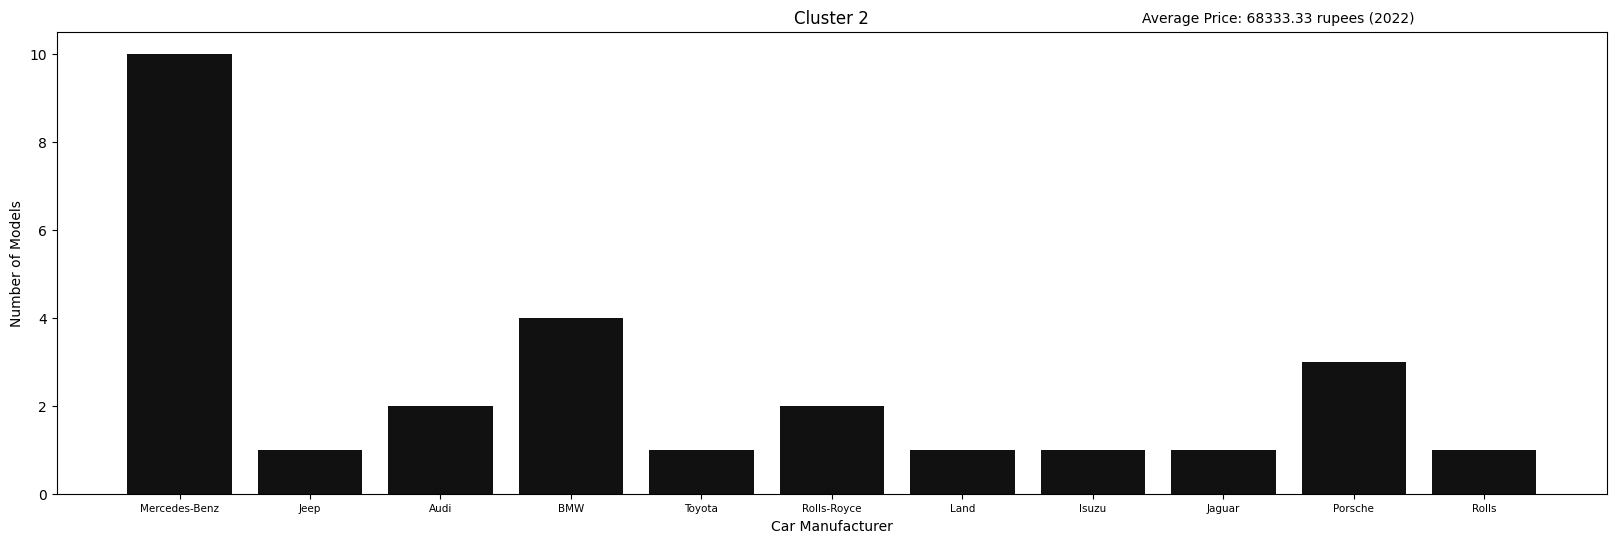

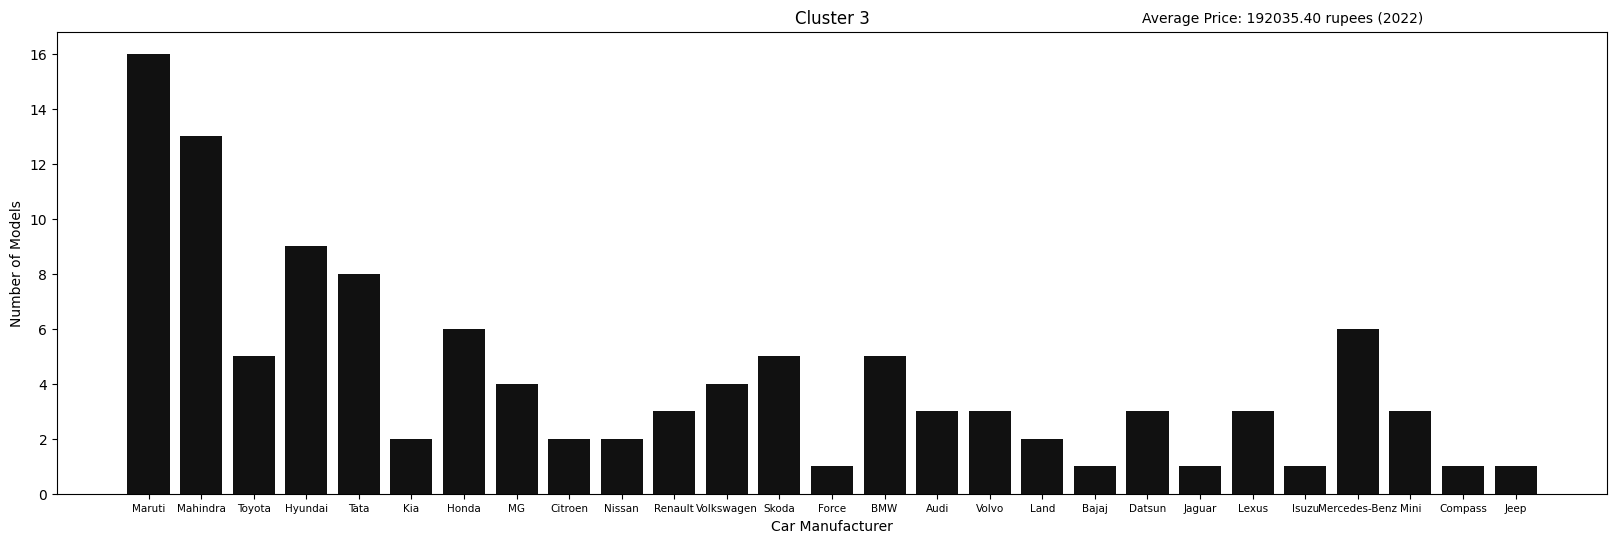

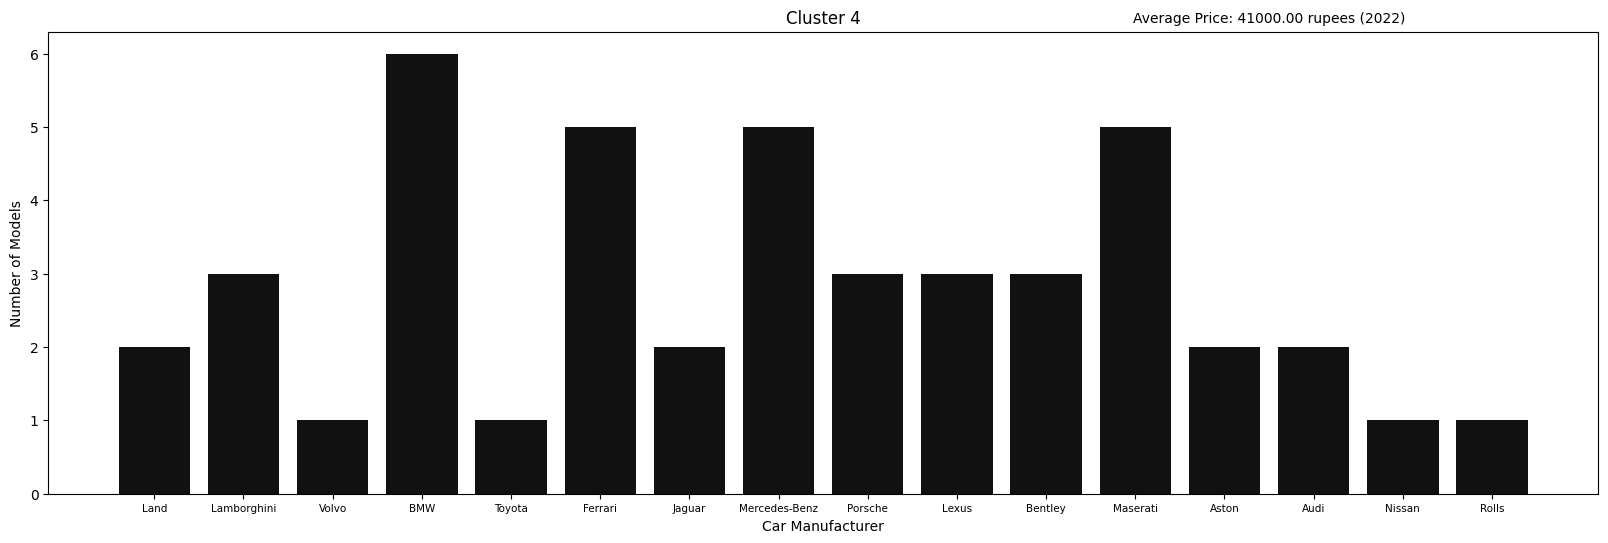

In [128]:
# analyze clusters

def graphCluster(names, clusters, clusterNum, startingPrice, endingPrice): 
    averagePrice = 0
    cluster = []
    for i in range(len(names)):
        if clusters[i] == clusterNum - 1:
            cluster.append(names[i])
            averagePrice = (startingPrice[i] + endingPrice[i]) / 2
            
    averagePrice /= len(cluster)
    text = "Average Price: {:.2f} rupees (2022)".format(averagePrice)
    
    nameFreq = {}
    for name in cluster:
        firstWord = name.split()[0]
        nameFreq[firstWord] = nameFreq.get(firstWord, 0) + 1
    
    plt.figure(figsize = (20, 6))
    plt.title("Cluster {}".format(clusterNum))
    plt.xlabel("Car Manufacturer")
    plt.ylabel("Number of Models")
    plt.bar(nameFreq.keys(), nameFreq.values(), color = '#111111')
    plt.xticks(fontsize = 7.5)
    plt.annotate(text, xy = (0.7, 1.02), xycoords = "axes fraction")
    # bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1')
    plt.show()
    plt.close()
    return

for i in range(1, 5):
    graphCluster(df["car_name"], clusters, i, startingPrice, endingPrice)
        